In [30]:
import pandas as pd
import numpy as np
import sys
import requests
import pprint

import datetime
import pytz
import importlib


import datetime, json, math
from google.cloud import bigquery
from numpy_ext import rolling_apply as rolling_apply_ext

In [3]:
import os

if os.path.exists('credential.json'):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')


In [4]:
gcp_project_id = "trading-290017"
bq_dataset_id = "market_data_binance"
bq_table_id = "by_minute"
bq_table_full_id = f'{gcp_project_id}.{bq_dataset_id}.{bq_table_id}'

_bq_client = bigquery.Client()

In [238]:
def read_df_binance_by_minute(date_str):
    query = """
        SELECT * 
        FROM `trading-290017.market_data_binance.by_minute` 
        WHERE TIMESTAMP_TRUNC(timestamp, DAY) = TIMESTAMP("{date}") 
        """.format(date=date_str)

    query_job = _bq_client.query(query)
    rows = query_job.result()  # Waits for query to finish
    row_dicts = []
    for row in query_job:
        # Row values can be accessed by field name or index.
        row_dict = {k: v for k, v in row.items()}
        row_dicts.append(row_dict)
    
    df = pd.DataFrame(row_dicts)
    df = df.sort_values(['symbol', 'timestamp'])
    return df

In [239]:
df = read_df_binance_by_minute("2023-08-11")

In [240]:
df.to_pickle('20230811.pkl')

In [291]:
df = pd.concat([pd.read_pickle('20230809.pkl'), pd.read_pickle('20230810.pkl')])

In [297]:
dfi = df.set_index(['symbol', 'timestamp'])

In [269]:
dfs = df.xs('MINAUSDT')

In [270]:
dfs

,open,high,low,close,volume
timestamp,,,,,
2023-08-09 00:00:00+00:00,0.456,0.456,0.455,0.456,1705.8
2023-08-09 00:01:00+00:00,0.456,0.456,0.454,0.455,3686.7
2023-08-09 00:02:00+00:00,0.455,0.455,0.455,0.455,1601.8
2023-08-09 00:03:00+00:00,0.455,0.455,0.455,0.455,6224.7
2023-08-09 00:04:00+00:00,0.455,0.455,0.455,0.455,0.0
...,...,...,...,...,...
2023-08-10 23:55:00+00:00,0.462,0.462,0.462,0.462,56.1
2023-08-10 23:56:00+00:00,0.461,0.462,0.461,0.462,3486.2
2023-08-10 23:57:00+00:00,0.462,0.462,0.462,0.462,2714.8


In [292]:
all_symbols = df.symbol.unique()

In [293]:
all_symbols

array(['1INCHBUSD', '1INCHUSDT', 'AAVEBUSD', 'AAVEUSDT', 'ACABUSD',
       'ACAUSDT', 'ACHBUSD', 'ACHUSDT', 'ACMUSDT', 'ADABUSD',
       'ADADOWNUSDT', 'ADAUPUSDT', 'ADAUSDT', 'ADXBUSD', 'ADXUSDT',
       'AERGOBUSD', 'AERGOUSDT', 'AGIXBUSD', 'AGIXUSDT', 'AGLDBUSD',
       'AGLDUSDT', 'AKROBUSD', 'AKROUSDT', 'ALCXBUSD', 'ALCXUSDT',
       'ALGOBUSD', 'ALGOUSDT', 'ALICEBUSD', 'ALICEUSDT', 'ALPACAUSDT',
       'ALPHABUSD', 'ALPHAUSDT', 'ALPINEBUSD', 'ALPINEUSDT', 'AMBBUSD',
       'AMBUSDT', 'AMPBUSD', 'AMPUSDT', 'ANKRBUSD', 'ANKRUSDT', 'ANTBUSD',
       'ANTUSDT', 'APEBUSD', 'APEUSDT', 'API3USDT', 'APTBUSD', 'APTUSDT',
       'ARBUSD', 'ARBUSDT', 'ARDRUSDT', 'ARKBUSD', 'ARKMUSDT', 'ARPABUSD',
       'ARPAUSDT', 'ARUSDT', 'ASRBUSD', 'ASRUSDT', 'ASTRBUSD', 'ASTRUSDT',
       'ASTUSDT', 'ATAUSDT', 'ATMBUSD', 'ATMUSDT', 'ATOMBUSD', 'ATOMUSDT',
       'AUCTIONBUSD', 'AUCTIONUSDT', 'AUDIOBUSD', 'AUDIOUSDT', 'AVABUSD',
       'AVAUSDT', 'AVAXBUSD', 'AVAXUSDT', 'AXSBUSD', 'AXSUSDT',
       'BAD

In [282]:
[s for s in all_symbols if s.startswith('M')]

['MAGICBUSD',
 'MAGICUSDT',
 'MANABUSD',
 'MANAUSDT',
 'MASKBUSD',
 'MASKUSDT',
 'MATICBUSD',
 'MATICUSDT',
 'MAVUSDT',
 'MBLBUSD',
 'MBLUSDT',
 'MBOXBUSD',
 'MBOXUSDT',
 'MCBUSD',
 'MCUSDT',
 'MDTBUSD',
 'MDTUSDT',
 'MDXBUSD',
 'MDXUSDT',
 'MINABUSD',
 'MINAUSDT',
 'MKRBUSD',
 'MKRUSDT',
 'MLNUSDT',
 'MOBBUSD',
 'MOBUSDT',
 'MOVRBUSD',
 'MOVRUSDT',
 'MTLBUSD',
 'MTLUSDT',
 'MULTIBUSD',
 'MULTIUSDT']

In [392]:
class Change:
    def __init__(self):
        self.ch, self.dist = None, 1
    def update(self, ch, dist):
        self.ch, self.dist = ch, dist
    def update_if_ch_larger(self, ch, dist):
        if self.ch is None or ch >= self.ch:
            self.update(ch, dist)
    def update_if_ch_lesser(self, ch, dist):
        if self.ch is None or ch <= self.ch:
            self.update(ch, dist)
    def change(self):
        return 0 if self.ch is None else self.ch
    def jitter(self):
        if self.ch is None:
            return 0
        return self.ch / self.dist
    def update_if_jitter_larger(self, ch, dist):
        if self.ch is None or ch / dist >= self.jitter():
            self.update(ch, dist)
    def update_if_jitter_lesser(self, ch, dist):
        if self.ch is None or ch / dist <= self.jitter():
            self.update(ch, dist)

In [393]:
def getJitterBackwardDict(dfw, symbol):
    l = len(dfw)
    if l < 1:
        return None
    pv = dfw.close.iloc[-1]
    most_jt, least_jt = Change(), Change()
    most_ch, least_ch = Change(), Change()
    for i, v in enumerate(dfw.close.iloc[:-2]):
        d = l-1-i;
        if v == 0: continue

        ch = (pv - v) / v
        most_ch.update_if_ch_larger(ch, d)
        least_ch.update_if_ch_lesser(ch, d)

        most_jt.update_if_jitter_larger(ch, d)
        least_jt.update_if_jitter_lesser(ch, d)

    return {
        'symbol': symbol, 'timestamp': dfw.timestamp.iloc[-1],
        'most_ch': most_ch.change(), 'least_ch': least_ch.change(), 'most_ch_d': most_ch.dist, 'least_ch_d': least_ch.dist,
        'most_jt': most_ch.jitter(), 'least_jt': least_ch.jitter(), 'most_jt_d': most_jt.dist, 'least_jt_d': least_jt.dist
        }

In [394]:
def getJitterForwardDict(dfw, symbol):
    l = len(dfw)
    if l < 1:
        return None
    pv = dfw.close.iloc[0]
    most_jt, least_jt = Change(), Change()
    most_ch, least_ch = Change(), Change()
    for i, v in enumerate(dfw.close.iloc[1:]):
        d = i+1;
        if v == 0: continue

        ch = (pv - v) / v
        most_ch.update_if_ch_larger(ch, d)
        least_ch.update_if_ch_lesser(ch, d)

        most_jt.update_if_jitter_larger(ch, d)
        least_jt.update_if_jitter_lesser(ch, d)

    return {
        'symbol': symbol, 'timestamp': dfw.timestamp.iloc[-1],
        'most_ch': most_ch.change(), 'least_ch': least_ch.change(), 'most_ch_d': most_ch.dist, 'least_ch_d': least_ch.dist,
        'most_jt': most_ch.jitter(), 'least_jt': least_ch.jitter(), 'most_jt_d': most_jt.dist, 'least_jt_d': least_jt.dist
        }

In [479]:
def getJitterRecoveryDict(dfw, initWindow, symbol):
    dfw_init = dfw.iloc[:initWindow]
    jitter_dict = getJitterBackwardDict(dfw_init, symbol)
    dfw_reverse = dfw.iloc[initWindow:]
    reverse_dict = getJitterForwardDict(dfw_reverse, symbol)
    if jitter_dict is None or reverse_dict is None:
        return None

    ret = {
        'symbol': symbol, 'timestamp': dfw.timestamp.iloc[-1],

        'jump_ch_recovery': -1 * jitter_dict['most_ch'] * reverse_dict['least_ch'], 'jump_ch_recovery_d': jitter_dict['most_ch_d'] + reverse_dict['least_ch_d'], 
        'drop_ch_recovery': -1 * jitter_dict['least_ch'] * reverse_dict['most_ch'], 'drop_ch_recovery_d': jitter_dict['least_ch_d'] + reverse_dict['most_ch_d'],        

        'jump_jitter_recovery': -1 * jitter_dict['most_jt'] * reverse_dict['least_jt'], 'jump_jitter_recovery_d': jitter_dict['most_jt_d'] + reverse_dict['least_jt_d'], 
        'drop_jitter_recovery': -1 * jitter_dict['least_jt'] * reverse_dict['most_jt'], 'drop_jitter_recovery_d': jitter_dict['least_jt_d'] + reverse_dict['most_jt_d'],
        }
    ret = {**ret, **{k + '_init': v for k, v in jitter_dict.items() if v != 'symbol' and v != 'timestamp'}}
    ret = {**ret, **{k + '_reverse': v for k, v in reverse_dict.items() if v != 'symbol' and v != 'timestamp'}}
    
    ret = {**ret, **{'jump_ch_rebound': min(jitter_dict['most_ch'], -1 * reverse_dict['least_ch']),
                     'drop_ch_rebound': min(-1 * jitter_dict['least_ch'], reverse_dict['most_ch']),
                  }
          }

    if ret['most_ch_init'] < 0:
        ret['jump_ch_recovery'] = None
        ret['jump_ch_recovery_d'] = None
        ret['jump_ch_rebound'] = None
    if ret['most_jt_init'] < 0:
        ret['jump_jt_recovery'] = None
        ret['jump_jt_recovery_d'] = None
    if ret['least_ch_init'] > 0:
        ret['drop_ch_recovery'] = None
        ret['drop_ch_recovery_d'] = None
        ret['drop_ch_rebound'] = None
    if ret['least_jt_init'] > 0:
        ret['drop_jt_recovery'] = None
        ret['drop_jt_recovery_d'] = None

    return ret

In [484]:
df_jitter_recovery_list = []
window_size_init = 30
window_size_recovery = 30
window_size = window_size_init + window_size_recovery
for symbol in all_symbols:
    dfs_ = df[df.symbol == symbol]
    dist_list = [getJitterRecoveryDict(dfw, window_size_init_jitter, symbol) for dfw in dfs_.rolling(window_size, min_periods=window_size)]
    df_jitter_recovery_list.append(pd.DataFrame([v for v in dist_list if v is not None]))
df_jitter_recoveries = pd.concat(df_jitter_recovery_list).set_index(['symbol', 'timestamp'])

In [485]:
df_jitter_recoveries

jump_ch_recovery  jump_ch_recovery_d  \
symbol    timestamp                                                         
1INCHBUSD 2023-08-09 00:30:00+00:00         -0.000000                 3.0   
          2023-08-09 00:31:00+00:00         -0.000000                 3.0   
          2023-08-09 00:32:00+00:00         -0.000000                 4.0   
          2023-08-09 00:33:00+00:00         -0.000000                 5.0   
          2023-08-09 00:34:00+00:00         -0.000000                 6.0   
...                                               ...                 ...   
ZRXUSDT   2023-08-10 23:55:00+00:00          0.000004                57.0   
          2023-08-10 23:56:00+00:00          0.000004                58.0   
          2023-08-10 23:57:00+00:00          0.000004                46.0   
          2023-08-10 23:58:00+00:00          0.000005                47.0   
          2023-08-10 23:59:00+00:00          0.000003                48.0   

                                     drop_ch_recovery  drop_ch_recovery_d  \
symbol    timestamp                                                         
1INCHBUSD 2023-08-09 00:30:00+00:00      0.000000e+00                 8.0   
          2023-08-09 00:31:00+00:00      0.000000e+00                 8.0   
          2023-08-09 00:32:00+00:00      0.000000e+00                 9.0   
          2023-08-09 00:33:00+00:00      0.000000e+00                10.0   
          2023-08-09 00:34:00+00:00      0.000000e+00                11.0   
...                                               ...                 ...   
ZRXUSDT   2023-08-10 23:55:00+00:00      8.899972e-07                10.0   
          2023-08-10 23:56:00+00:00      8.899972e-07                10.0   
          2023-08-10 23:57:00+00:00      8.899972e-07                10.0   
          2023-08-10 23:58:00+00:00      0.000000e+00                10.0   
          2023-08-10 23:59:00+00:00      0.000000e+00                10.0   

                                     jump_jitter_recovery  \
symbol    timestamp                                         
1INCHBUSD 2023-08-09 00:30:00+00:00         -0.000000e+00   
          2023-08-09 00:31:00+00:00         -0.000000e+00   
          2023-08-09 00:32:00+00:00         -0.000000e+00   
          2023-08-09 00:33:00+00:00         -0.000000e+00   
          2023-08-09 00:34:00+00:00         -0.000000e+00   
...                                                   ...   
ZRXUSDT   2023-08-10 23:55:00+00:00          5.482884e-09   
          2023-08-10 23:56:00+00:00          5.293819e-09   
          2023-08-10 23:57:00+00:00          7.221092e-09   
          2023-08-10 23:58:00+00:00          1.022988e-08   
          2023-08-10 23:59:00+00:00          4.845733e-09   

                                     jump_jitter_recovery_d  \
symbol    timestamp                                           
1INCHBUSD 2023-08-09 00:30:00+00:00                       3   
          2023-08-09 00:31:00+00:00                       3   
          2023-08-09 00:32:00+00:00                       4   
          2023-08-09 00:33:00+00:00                       5   
          2023-08-09 00:34:00+00:00                       6   
...                                                     ...   
ZRXUSDT   2023-08-10 23:55:00+00:00                      44   
          2023-08-10 23:56:00+00:00                      44   
          2023-08-10 23:57:00+00:00                      44   
          2023-08-10 23:58:00+00:00                      21   
          2023-08-10 23:59:00+00:00                      21   

                                     drop_jitter_recovery  \
symbol    timestamp                                         
1INCHBUSD 2023-08-09 00:30:00+00:00          0.000000e+00   
          2023-08-09 00:31:00+00:00          0.000000e+00   
          2023-08-09 00:32:00+00:00          0.000000e+00   
          2023-08-09 00:33:00+00:00          0.000000e+00   
          2023-08-09 00:34:00+00:00          0.000000

In [486]:
df_jitter_recoveries.to_pickle('jitter_recoveries.pkl')

In [487]:
df_jitter_recoveries[(df_jitter_recoveries.jump_ch_recovery > 0.1 * 0.06)]

jump_ch_recovery  jump_ch_recovery_d  \
symbol   timestamp                                                         
AKROBUSD 2023-08-09 12:38:00+00:00          0.006569                37.0   
         2023-08-09 12:41:00+00:00          0.008278                37.0   
         2023-08-09 12:44:00+00:00          0.007181                37.0   
         2023-08-09 12:47:00+00:00          0.006615                37.0   
         2023-08-09 12:59:00+00:00          0.006529                51.0   
...                                              ...                 ...   
SNMBUSD  2023-08-09 16:26:00+00:00          0.008195                29.0   
         2023-08-09 16:27:00+00:00          0.007182                29.0   
         2023-08-09 16:28:00+00:00          0.008426                29.0   
         2023-08-09 16:29:00+00:00          0.007503                29.0   
         2023-08-09 16:30:00+00:00          0.007179                29.0   

                                    drop_ch_recovery  drop_ch_recovery_d  \
symbol   timestamp                                                         
AKROBUSD 2023-08-09 12:38:00+00:00               NaN                 NaN   
         2023-08-09 12:41:00+00:00               NaN                 NaN   
         2023-08-09 12:44:00+00:00               NaN                 NaN   
         2023-08-09 12:47:00+00:00         -0.000052                20.0   
         2023-08-09 12:59:00+00:00          0.000142                 7.0   
...                                              ...                 ...   
SNMBUSD  2023-08-09 16:26:00+00:00         -0.000038                21.0   
         2023-08-09 16:27:00+00:00          0.000426                31.0   
         2023-08-09 16:28:00+00:00          0.000188                31.0   
         2023-08-09 16:29:00+00:00          0.000355                33.0   
         2023-08-09 16:30:00+00:00          0.000391                33.0   

                                    jump_jitter_recovery  ...  \
symbol   timestamp                                        ...   
AKROBUSD 2023-08-09 12:38:00+00:00              0.000019  ...   
         2023-08-09 12:41:00+00:00              0.000026  ...   
         2023-08-09 12:44:00+00:00              0.000025  ...   
         2023-08-09 12:47:00+00:00              0.000029  ...   
         2023-08-09 12:59:00+00:00              0.000010  ...   
...                                                  ...  ...   
SNMBUSD  2023-08-09 16:26:00+00:00              0.000053  ...   
         2023-08-09 16:27:00+00:00              0.000052  ...   
         2023-08-09 16:28:00+00:00              0.000070  ...   
         2023-08-09 16:29:00+00:00              0.000075  ...   
         2023-08-09 16:30:00+00:00              0.000092  ...   

                                    drop_ch_rebound  jump_jt_recovery  \
symbol   timestamp                                                      
AKROBUSD 2023-08-09 12:38:00+00:00              NaN               NaN   
         2023-08-09 12:41:00+00:00              NaN               NaN   
         2023-08-09 12:44:00+00:00              NaN               NaN   
         2023-08-09 12:47:00+00:00        -0.002448               NaN   
         2023-08-09 12:59:00+00:00         0.010539               NaN   
...                                             ...               ...   
SNMBUSD  2023-08-09 16:26:00+00:00        -0.002817               NaN   
         2023-08-09 16:27:00+00:00         0.019029               NaN   
         2023-08-09 16:28:00+00:00         0.013321               NaN   
         2023-08-09 16:29:00+00:00         0.018078               NaN   
         2023-08-09 16:30:00+00:00         0.015035               NaN   

                                    jump_jt_recovery_d drop_jt_recovery  \
symbol   timestamp                                                        
AKROBUSD 2023-08-09 12:38:00+00:00                 NaN              NaN   
         2023-08-09 12:41:00+00:00   

In [488]:
df_jitter_recoveries[(df_jitter_recoveries.jump_ch_recovery > 0.1 * 0.06)].index.get_level_values(0).unique()

Index(['AKROBUSD', 'AKROUSDT', 'BNTUSDT', 'DODOBUSD', 'DODOUSDT', 'DREPBUSD',
       'DREPUSDT', 'OXTUSDT', 'SNMBUSD'],
      dtype='object', name='symbol')

In [489]:
df_jitter_recoveries.columns

Index(['jump_ch_recovery', 'jump_ch_recovery_d', 'drop_ch_recovery',
       'drop_ch_recovery_d', 'jump_jitter_recovery', 'jump_jitter_recovery_d',
       'drop_jitter_recovery', 'drop_jitter_recovery_d', 'symbol_init',
       'timestamp_init', 'most_ch_init', 'least_ch_init', 'most_ch_d_init',
       'least_ch_d_init', 'most_jt_init', 'least_jt_init', 'most_jt_d_init',
       'least_jt_d_init', 'symbol_reverse', 'timestamp_reverse',
       'most_ch_reverse', 'least_ch_reverse', 'most_ch_d_reverse',
       'least_ch_d_reverse', 'most_jt_reverse', 'least_jt_reverse',
       'most_jt_d_reverse', 'least_jt_d_reverse', 'jump_ch_rebound',
       'drop_ch_rebound', 'jump_jt_recovery', 'jump_jt_recovery_d',
       'drop_jt_recovery', 'drop_jt_recovery_d'],
      dtype='object')

<Axes: >

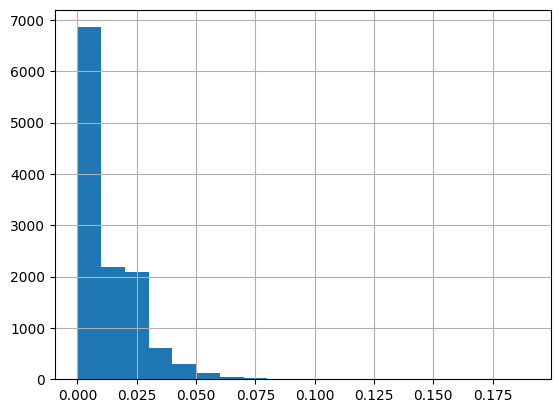

In [495]:
df_jitter_recoveries[df_jitter_recoveries.most_ch_init > 0.02].jump_ch_rebound.hist(bins=[i * 0.01 for i in range(20)])

<Axes: xlabel='most_ch_init', ylabel='least_ch_reverse'>

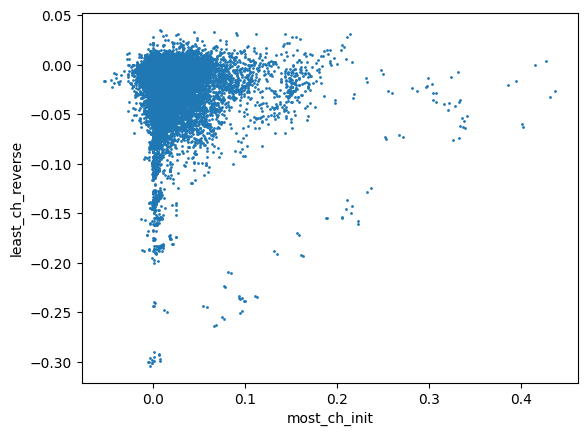

In [419]:
df_jitter_recoveries.plot.scatter(x='most_ch_init', y='least_ch_reverse', s=1)

In [456]:
labels = list(range(-40, 41))
bins = [i * 0.01 for i in labels]
df_jitter_recoveries['most_ch_bin_init'] = pd.cut(df_jitter_recoveries['most_ch_init'], bins=bins, labels=labels[1:])
df_jitter_recoveries['least_ch_bin_init'] = pd.cut(df_jitter_recoveries['least_ch_init'], bins=bins, labels=labels[1:])

<Axes: xlabel='most_ch_bin_init', ylabel='least_ch_reverse'>

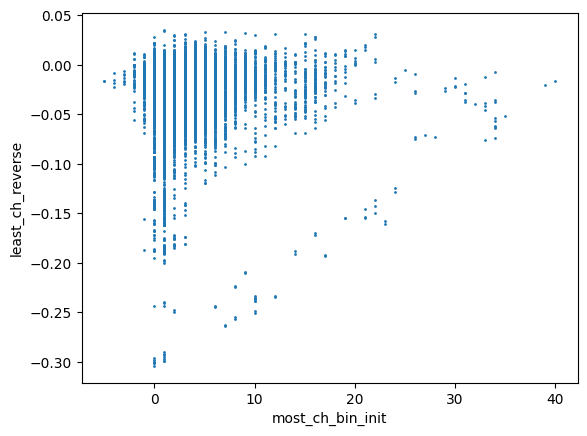

In [457]:
df_jitter_recoveries.plot.scatter(x='most_ch_bin_init', y='least_ch_reverse', s=1)

<Axes: xlabel='most_ch_bin_init'>

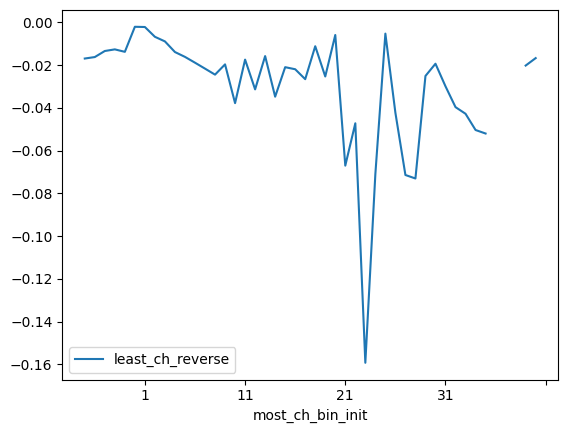

In [458]:
df_jitter_recoveries.groupby(['most_ch_bin_init'])[['least_ch_reverse']].mean().plot()

<Axes: xlabel='most_jt_init', ylabel='least_ch_reverse'>

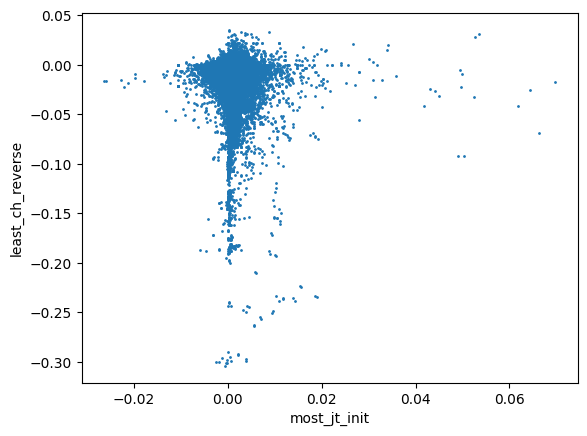

In [420]:
df_jitter_recoveries.plot.scatter(x='most_jt_init', y='least_ch_reverse', s=1)

<Axes: xlabel='most_ch_init', ylabel='jump_ch_recovery'>

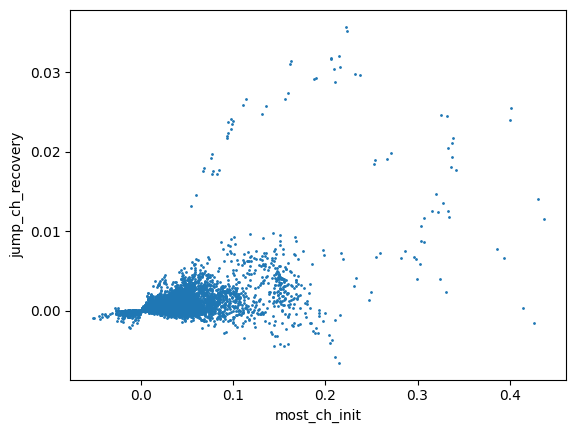

In [454]:
df_jitter_recoveries.plot.scatter(x='most_ch_init', y='jump_ch_recovery', s=1)

<Axes: xlabel='most_ch_bin_init'>

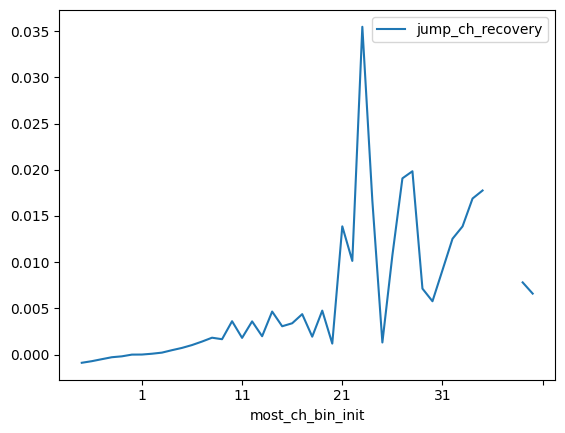

In [459]:
df_jitter_recoveries.groupby(['most_ch_bin_init'])[['jump_ch_recovery']].mean().plot()

<Axes: xlabel='least_ch_init', ylabel='most_ch_reverse'>

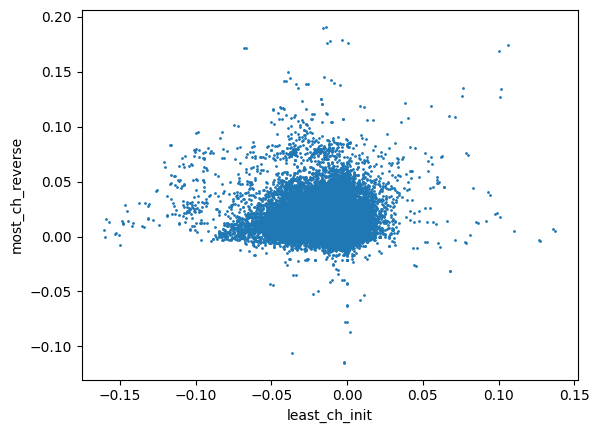

In [421]:
df_jitter_recoveries.plot.scatter(x='least_ch_init', y='most_ch_reverse', s=1)

<Axes: xlabel='least_ch_bin_init'>

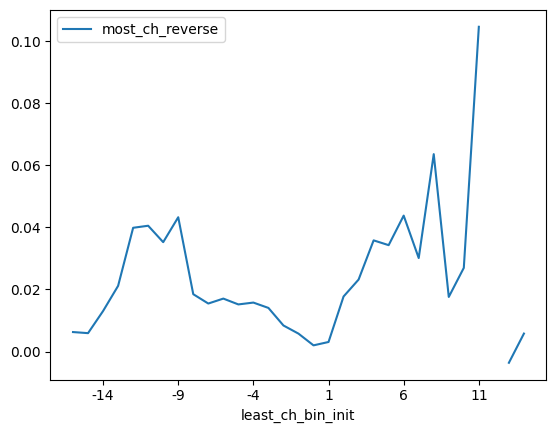

In [461]:
df_jitter_recoveries.groupby(['least_ch_bin_init'])[['most_ch_reverse']].mean().plot()

<Axes: xlabel='least_ch_init', ylabel='drop_ch_recovery'>

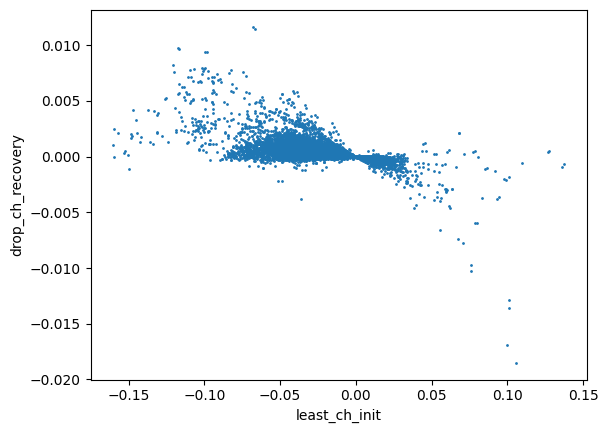

In [462]:
df_jitter_recoveries.plot.scatter(x='least_ch_init', y='drop_ch_recovery', s=1)

<Axes: xlabel='least_ch_bin_init'>

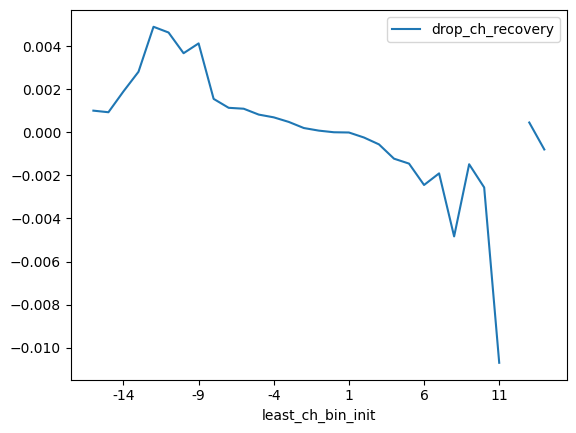

In [463]:
df_jitter_recoveries.groupby(['least_ch_bin_init'])[['drop_ch_recovery']].mean().plot()

In [295]:
df_jitter_list = []
window_size = 30
for symbol in all_symbols:
    dfs_ = df[df.symbol == symbol]
    df_jitter_list.append(pd.DataFrame([getJitterBackwardDict(dfw, symbol) for dfw in dfs_.rolling(window_size, min_periods=window_size)]))
df_jitters = pd.concat(df_jitter_list).set_index(['symbol', 'timestamp'])

In [298]:
df_jitters.to_pickle('jitters.pkl')

In [306]:
df_jitters[df_jitters.most_ch > 0.1]

most_ch  least_ch  most_ch_d  least_ch_d  \
symbol   timestamp                                                              
AKROBUSD 2023-08-09 12:10:00+00:00  0.118384  0.000000         22           1   
         2023-08-09 12:11:00+00:00  0.150418  0.000000         23           1   
         2023-08-09 12:12:00+00:00  0.123955  0.000000         24           1   
         2023-08-09 12:13:00+00:00  0.169916  0.000000         25           1   
         2023-08-09 12:14:00+00:00  0.165738  0.000000         26           1   
...                                      ...       ...        ...         ...   
TKOUSDT  2023-08-09 09:14:00+00:00  0.122159  0.000000         13           1   
         2023-08-09 09:16:00+00:00  0.101461 -0.019154         15           3   
         2023-08-09 09:17:00+00:00  0.103490 -0.017347         16           4   
         2023-08-09 09:24:00+00:00  0.100244 -0.020239         23          11   
         2023-08-09 09:25:00+00:00  0.108766 -0.012649         24          12   

                                     most_jt  least_jt  most_jt_d  least_jt_d  
symbol   timestamp                                                             
AKROBUSD 2023-08-09 12:10:00+00:00  0.005381  0.000000          3           1  
         2023-08-09 12:11:00+00:00  0.006540  0.000000          4           1  
         2023-08-09 12:12:00+00:00  0.005165  0.000000          5           1  
         2023-08-09 12:13:00+00:00  0.006797  0.000000          6           1  
         2023-08-09 12:14:00+00:00  0.006375  0.000000          7           1  
...                                      ...       ...        ...         ...  
TKOUSDT  2023-08-09 09:14:00+00:00  0.009397  0.000000          7           1  
         2023-08-09 09:16:00+00:00  0.006764 -0.006385         14           2  
         2023-08-09 09:17:00+00:00  0.006468 -0.004337         15           3  
         2023-08-09 09:24:00+00:00  0.004358 -0.001840          2          10  
         2023-08-09 09:25:00+00:00  0.004532 -0.001054          2          11  

[451 rows x 8 columns]

In [310]:
df_jitters[df_jitters.most_ch > 0.1].index.get_level_values(0).unique()

Index(['AKROBUSD', 'AKROUSDT', 'APTBUSD', 'APTUSDT', 'BARUSDT', 'BNTUSDT',
       'CLVBUSD', 'CLVUSDT', 'DODOBUSD', 'DODOUSDT', 'DREPBUSD', 'DREPUSDT',
       'GLMBUSD', 'GLMUSDT', 'MULTIBUSD', 'OXTUSDT', 'SNMBUSD', 'STGBUSD',
       'STGUSDT', 'TKOBUSD', 'TKOUSDT'],
      dtype='object', name='symbol')

<Axes: xlabel='timestamp'>

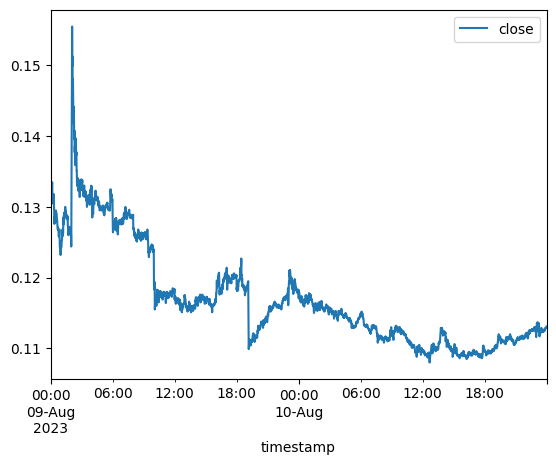

In [356]:
df[df.symbol == 'DODOUSDT'].set_index('timestamp')[['close']].plot()

<Axes: xlabel='timestamp'>

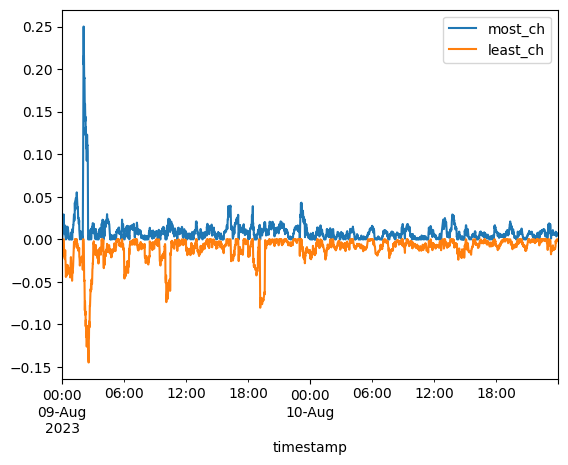

In [357]:
df_jitters.xs('DODOUSDT')[['most_ch', 'least_ch']].plot()

<Axes: xlabel='timestamp'>

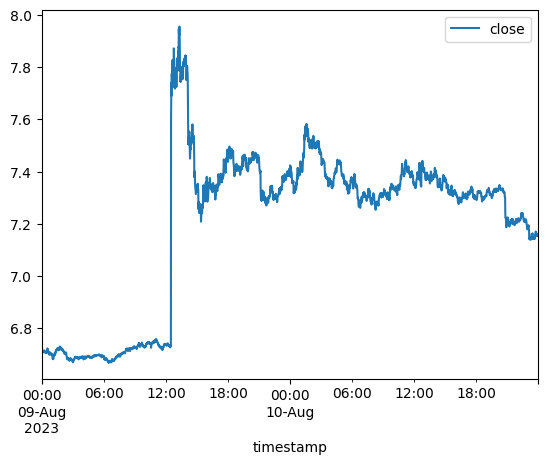

In [313]:
df[df.symbol == 'APTUSDT'].set_index('timestamp')[['close']].plot()

<Axes: xlabel='timestamp'>

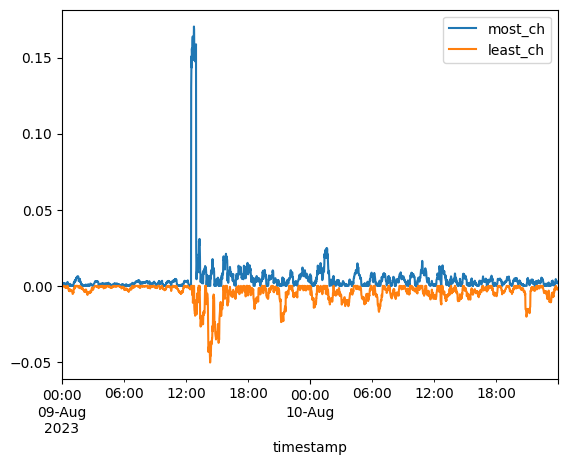

In [319]:
df_jitters.xs('APTUSDT')[['most_ch', 'least_ch']].plot()

<Axes: xlabel='timestamp'>

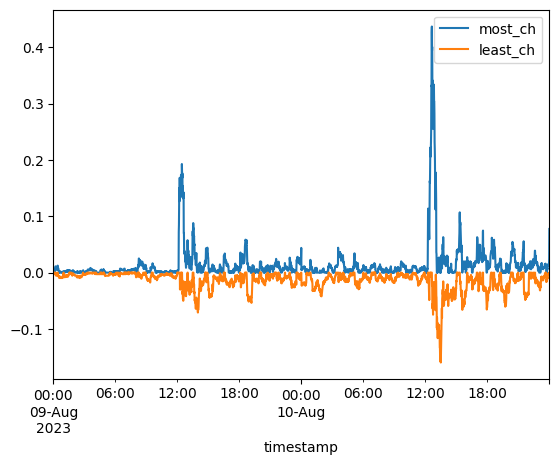

In [312]:
df_jitters.xs('AKROUSDT')[['most_ch', 'least_ch']].plot()